In [ ]:
%matplotlib inline


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [22]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.         -1.8096584  ... -0.45680285  0.
    0.        ]
  ...
  [ 0.          0.         -0.6622999  ...  1.0673003   0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.         -1.3354341  ...  1.8333333   0.
    0.        ]
  ...
  [ 0.          0.         -1.055322   ...  1.2556022   0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.   

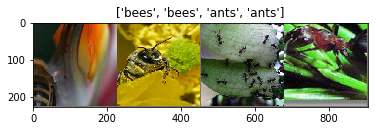

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
   
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Zhiyang/.torch\models\resnet18-5c106cde.pth
100.0%


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5949 Acc: 0.6516
val Loss: 0.2990 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.5980 Acc: 0.7541
val Loss: 0.4683 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.3621 Acc: 0.8361
val Loss: 0.3821 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.3740 Acc: 0.8279
val Loss: 0.3113 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5476 Acc: 0.7787
val Loss: 0.7209 Acc: 0.7778

Epoch 5/24
----------
train Loss: 0.5826 Acc: 0.7869
val Loss: 0.4722 Acc: 0.7908

Epoch 6/24
----------
train Loss: 0.5697 Acc: 0.7992
val Loss: 0.6018 Acc: 0.7778

Epoch 7/24
----------
train Loss: 0.4466 Acc: 0.8279
val Loss: 0.2264 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3065 Acc: 0.8566
val Loss: 0.2465 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.3375 Acc: 0.8730
val Loss: 0.2385 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3190 Acc: 0.8607
val Loss: 0.2087 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2667 Acc: 0.8893
val Loss: 0.2159 Acc: 0.9150

Ep

[[[0.878928   0.878928   0.9131775  ... 0.15968838 0.17681314 0.24531215]
  [0.878928   0.878928   0.878928   ... 0.21106265 0.2624369  0.2624369 ]
  [0.86180323 0.8446785  0.8446785  ... 0.2281874  0.24531215 0.21106265]
  ...
  [0.74193    0.45080918 0.31381115 ... 0.70768046 0.79330426 0.8446785 ]
  [0.82755375 0.46793392 0.31381115 ... 0.70768046 0.7590547  0.82755375]
  [0.8960528  0.60493195 0.2966864  ... 0.70768046 0.74193    0.82755375]]

 [[1.0280112  1.0280112  1.0630252  ... 0.29271722 0.3102242  0.3802522 ]
  [1.0280112  1.0280112  1.0280112  ... 0.3452382  0.3977592  0.3977592 ]
  [1.0105042  0.9929972  0.9929972  ... 0.3627452  0.3802522  0.3452382 ]
  ...
  [0.88795525 0.5903362  0.45028022 ... 0.8529412  0.94047624 0.9929972 ]
  [0.9754903  0.6078432  0.45028022 ... 0.8529412  0.90546227 0.9754903 ]
  [1.0455183  0.74789923 0.4327732  ... 0.8529412  0.88795525 0.9754903 ]]

 [[1.2456646  1.2456646  1.2805231  ... 0.51363856 0.5310677  0.6007845 ]
  [1.2456646  1.245664

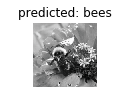

[[[2.1975338 2.1975338 2.1461596 ... 2.0262864 2.0091617 1.923538 ]
  [2.2146587 2.1804092 2.129035  ... 2.060536  2.060536  2.0262864]
  [2.2146587 2.2146587 2.11191   ... 2.1632845 2.11191   1.923538 ]
  ...
  [1.6837914 1.6495419 1.4782944 ... 1.4954191 1.5296686 0.9988013]
  [1.8036647 1.6152923 1.2556726 ... 1.5810429 1.42692   1.221423 ]
  [1.8721637 1.6324171 1.1700488 ... 1.8207895 1.6152923 1.1700488]]

 [[2.3760502 2.3760502 2.3760502 ... 2.3060222 2.3060222 2.2009804]
  [2.3935575 2.3760502 2.3585434 ... 2.3585434 2.3235295 2.2535014]
  [2.3935575 2.4110641 2.3585434 ... 2.3760502 2.3585434 2.2184873]
  ...
  [2.0434172 2.0259104 1.9908963 ... 1.8508403 1.8508403 1.3431373]
  [2.1834733 2.0784314 1.7808123 ... 1.9208683 1.7282913 1.5357143]
  [2.2535014 2.1134453 1.6407562 ... 2.1134453 1.8683473 1.4306723]]

 [[2.5702832 2.5702832 2.5877128 ... 2.5702832 2.5702832 2.5179958]
  [2.6051416 2.5877128 2.5877128 ... 2.5877128 2.5702832 2.5005665]
  [2.6051416 2.622571  2.5877128

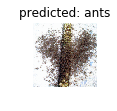

[[[-0.5424266  -0.5081771  -0.45680285 ... -0.78217316 -0.79929787
   -0.91917115]
  [-0.35405433 -0.35405433 -0.31980482 ... -0.78217316 -0.95342064
   -1.073294  ]
  [-0.2170563  -0.18280679 -0.19993155 ... -0.9362959  -1.073294
   -1.1760426 ]
  ...
  [-1.5014129  -1.4842881  -1.4671633  ... -1.9124069  -1.9466565
   -1.9295317 ]
  [-1.5014129  -1.5014129  -1.4842881  ... -1.8781574  -1.9124069
   -1.9466565 ]
  [-1.5014129  -1.5014129  -1.4842881  ... -1.9295317  -1.9466565
   -1.9466565 ]]

 [[-0.10994396 -0.07492995  0.01260505 ... -0.35504198 -0.42507
   -0.512605  ]
  [ 0.04761905  0.08263306  0.13515405 ... -0.35504198 -0.547619
   -0.65266097]
  [ 0.17016806  0.2226892   0.2401962  ... -0.495098   -0.670168
   -0.740196  ]
  ...
  [-1.0728291  -1.0378151  -1.0378151  ... -1.6855742  -1.7556022
   -1.7556022 ]
  [-1.055322   -1.055322   -1.0728291  ... -1.6855742  -1.7205882
   -1.7556022 ]
  [-1.0728291  -1.0903361  -1.0903361  ... -1.7380952  -1.7731092
   -1.7556022 ]]

 [[

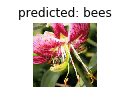

[[[ 1.8207895   1.7694151   1.8207895  ...  2.1461596   2.129035
    2.1804092 ]
  [ 1.8036647   1.7694151   1.8036647  ...  1.8036647   1.8207895
    1.8550389 ]
  [ 1.0330508   1.1186745   1.1700488  ...  1.7522904   1.6837914
    1.6837914 ]
  ...
  [-0.5081771  -0.19993155 -0.25130582 ...  2.129035    2.129035
    2.129035  ]
  [-0.57667613 -0.19993155 -0.19993155 ...  2.1804092   2.1804092
    2.1804092 ]
  [-0.4739276  -0.19993155 -0.16568205 ...  1.2385478   1.2385478
    1.3412963 ]]

 [[ 1.8858544   1.8333333   1.8508403  ...  2.2184873   2.2184873
    2.1834733 ]
  [ 1.8158263   1.8508403   1.9033613  ...  1.8683473   1.8683473
    1.8508403 ]
  [ 1.2556022   1.3081232   1.3431373  ...  1.7633053   1.7457983
    1.7457983 ]
  ...
  [-0.12745096  0.08263306  0.04761905 ...  2.3585434   2.3585434
    2.3585434 ]
  [-0.14495796  0.06512605  0.08263306 ...  2.3410363   2.3410363
    2.3585434 ]
  [-0.19747896  0.10014006  0.11764706 ...  1.2556022   1.2380953
    1.3081232 ]]

 [

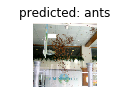

[[[-1.3472902  -1.3472902  -1.3644148  ... -1.3301654  -1.3301654
   -1.3472902 ]
  [-1.3472902  -1.3472902  -1.3472902  ... -1.3472902  -1.3472902
   -1.3644148 ]
  [-1.3130406  -1.3130406  -1.3472902  ... -1.3644148  -1.3815396
   -1.3815396 ]
  ...
  [ 1.8892884   1.7865399   1.923538   ... -1.3815396  -1.3815396
   -1.3644148 ]
  [ 1.8379141   1.8550389   1.923538   ... -1.3986644  -1.3644148
   -1.3472902 ]
  [ 1.8036647   1.9406626   1.923538   ... -1.3815396  -1.3644148
   -1.3472902 ]]

 [[-1.107843   -1.107843   -1.0903361  ... -1.177871   -1.177871
   -1.160364  ]
  [-1.0903361  -1.0728291  -1.055322   ... -1.1953781  -1.1953781
   -1.212885  ]
  [-1.055322   -1.0378151  -1.0028011  ... -1.212885   -1.230392
   -1.230392  ]
  ...
  [ 1.9033613   1.9033613   2.0784314  ... -0.93277305 -0.93277305
   -0.9502801 ]
  [ 1.8508403   1.9733893   2.0959384  ... -0.9677871  -0.9677871
   -0.9677871 ]
  [ 1.8333333   2.0434172   2.0959384  ... -0.9677871  -0.9677871
   -0.9852941 ]]

 

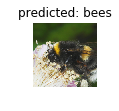

[[[ 1.015926    0.96455175  0.86180323 ... -0.08005828  0.03981499
    0.21106265]
  [ 1.2556726   1.2727973   1.1529241  ...  0.03981499  0.2281874
    0.38231018]
  [ 1.42692     1.4611696   1.2899221  ...  0.31381115  0.43368444
    0.5364329 ]
  ...
  [ 1.0844251   0.96455175  0.63918144 ... -0.4739276  -0.6622999
   -0.59380084]
  [ 0.9816765   0.86180323  0.14256364 ... -0.45680285 -0.6109256
   -0.7307989 ]
  [ 0.39943492  0.12543888 -0.2855553  ... -0.4739276  -0.6622999
   -0.7136741 ]]

 [[ 1.2030813   1.1330533   0.9929972  ...  0.10014006  0.2577032
    0.3802522 ]
  [ 1.3956583   1.3781513   1.2556022  ...  0.17016806  0.3452382
    0.45028022]
  [ 1.5532213   1.5182073   1.4306723  ...  0.41526622  0.48529422
    0.5378152 ]
  ...
  [ 1.1680672   1.0105042   0.6778712  ... -0.07492995 -0.30252096
   -0.30252096]
  [ 1.1155462   0.94047624  0.15266106 ... -0.19747896 -0.37254897
   -0.512605  ]
  [ 0.4677872   0.13515405 -0.40756297 ... -0.33753496 -0.512605
   -0.547619  

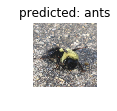

In [18]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [19]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [20]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6153 Acc: 0.6475
val Loss: 0.2872 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.5936 Acc: 0.7500
val Loss: 0.1952 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4573 Acc: 0.7951
val Loss: 0.2704 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4039 Acc: 0.8156
val Loss: 0.3498 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.5418 Acc: 0.7910
val Loss: 0.1760 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4864 Acc: 0.7787
val Loss: 0.2006 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3581 Acc: 0.8525
val Loss: 0.2078 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3603 Acc: 0.8484
val Loss: 0.1874 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3141 Acc: 0.8566
val Loss: 0.1907 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4201 Acc: 0.8033
val Loss: 0.1935 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3229 Acc: 0.8484
val Loss: 0.1941 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2750 Acc: 0.8811
val Loss: 0.1852 Acc: 0.9412

Ep

[[[ 1.0330508   1.1015497   1.1015497  ...  0.9816765   1.015926
    1.0501755 ]
  [ 1.0501755   1.0501755   1.0844251  ...  0.9988013   1.015926
    1.0330508 ]
  [ 1.0673003   1.0330508   1.0501755  ...  0.96455175  0.9988013
    0.9816765 ]
  ...
  [ 2.2317834   2.2489083   2.2489083  ...  0.72480524  0.5535577
    0.93030226]
  [ 2.2317834   2.2489083   2.2489083  ...  0.673431    0.6220567
    0.7590547 ]
  [ 2.2146587   2.2317834   2.2489083  ...  1.42692     1.0501755
    0.63918144]]

 [[ 0.48529422  0.5203082   0.5203082  ...  0.3277312   0.3627452
    0.41526622]
  [ 0.4677872   0.4677872   0.48529422 ...  0.3452382   0.3627452
    0.3802522 ]
  [ 0.4327732   0.4327732   0.45028022 ...  0.3627452   0.3977592
    0.3802522 ]
  ...
  [ 0.01260505  0.04761905  0.04761905 ... -0.30252096 -0.495098
   -0.09243695]
  [ 0.06512605  0.06512605  0.06512605 ... -0.33753496 -0.44257697
   -0.26750696]
  [ 0.06512605  0.03011205  0.04761905 ...  0.69537824  0.2577032
   -0.40756297]]

 [

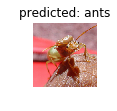

[[[ 0.79330426  0.96455175  1.1700488  ...  0.41655967  0.38231018
    0.38231018]
  [ 0.82755375  0.8446785   0.9988013  ...  0.34806067  0.38231018
    0.41655967]
  [ 0.82755375  0.7761795   0.86180323 ...  0.27956167  0.3651854
    0.41655967]
  ...
  [ 0.05693974  0.15968838  0.14256364 ... -1.8781574  -1.5014129
   -1.3644148 ]
  [ 0.50218344 -0.06293353 -0.11430778 ... -1.7411594  -1.3986644
   -1.2616663 ]
  [ 0.72480524  0.57068247 -0.16568205 ... -1.5185376  -1.2787911
   -1.1931673 ]]

 [[ 1.1155462   1.2556022   1.4481792  ...  0.81792724  0.8004202
    0.8529412 ]
  [ 1.1680672   1.1855743   1.3081232  ...  0.76540625  0.8004202
    0.88795525]
  [ 1.1855743   1.1330533   1.2030813  ...  0.71288526  0.8004202
    0.90546227]
  ...
  [ 0.2577032   0.45028022  0.3977592  ... -1.8081232  -1.4404761
   -1.2829131 ]
  [ 0.4677872   0.06512605  0.10014006 ... -1.6855742  -1.352941
   -1.177871  ]
  [ 0.3977592   0.41526622 -0.19747896 ... -1.457983   -1.230392
   -1.107843  ]]



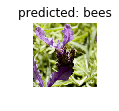

[[[-0.9876702  -1.0390445  -1.0390445  ... -1.2445416  -1.4842881
   -1.4842881 ]
  [-0.8506721  -0.9705454  -1.0390445  ... -1.6212862  -1.6212862
   -0.7136741 ]
  [-0.7307989  -0.8677969  -1.0390445  ... -1.1075436  -2.0494049
    0.57068247]
  ...
  [ 0.09118938  0.41655967 -0.18280679 ...  0.03981499 -0.23418105
   -0.42255333]
  [-0.23418105 -0.26843056 -0.25130582 ... -0.2170563  -0.55955136
   -0.38830382]
  [-1.0561693  -0.13143253  1.2727973  ... -0.04580877 -0.38830382
   -0.25130582]]

 [[-1.230392   -1.265406   -1.265406   ... -1.4229691  -1.5805322
   -1.5280112 ]
  [-1.055322   -1.160364   -1.247899   ... -1.6855742  -1.8256302
   -0.722689  ]
  [-0.897759   -1.055322   -1.247899   ... -1.230392   -1.9306722
    0.74789923]
  ...
  [-0.17997196  0.13515405 -0.37254897 ... -0.14495796 -0.40756297
   -0.705182  ]
  [-0.617647   -0.512605   -0.42507    ... -0.495098   -0.757703
   -0.53011197]
  [-1.3354341  -0.19747896  1.3956583  ... -0.37254897 -0.60014
   -0.32002798]]


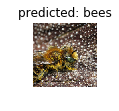

[[[-0.30268008 -0.26843056 -0.19993155 ... -0.09718303 -0.06293353
   -0.11430778]
  [-0.23418105 -0.11430778 -0.11430778 ... -0.13143253 -0.09718303
   -0.11430778]
  [-0.11430778 -0.04580877 -0.18280679 ... -0.11430778 -0.14855729
   -0.11430778]
  ...
  [ 0.3651854   0.2624369  -0.35405433 ... -1.4842881  -1.6897851
   -1.7069099 ]
  [-0.43967807 -0.14855729  0.09118938 ... -1.4671633  -1.5014129
   -1.6041614 ]
  [-0.6451751  -0.6109256  -0.55955136 ... -1.5185376  -1.5014129
   -1.5356624 ]]

 [[-0.14495796  0.03011205  0.2051822  ...  1.1155462   1.0630252
    1.0630252 ]
  [ 0.01260505  0.2051822   0.17016806 ...  1.0805323   1.0455183
    1.0630252 ]
  [ 0.13515405  0.29271722  0.17016806 ...  1.0630252   1.0105042
    1.0630252 ]
  ...
  [ 0.55532223  0.4327732   0.2051822  ... -0.77521    -0.862745
   -0.897759  ]
  [ 0.11764706  0.18767506  0.17016806 ... -0.77521    -0.862745
   -0.897759  ]
  [-0.07492995 -0.16246496 -0.16246496 ... -0.827731   -0.93277305
   -0.897759  ]]

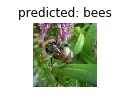

[[[-0.6280504  -0.67942464 -0.67942464 ...  1.3755459   1.3755459
    1.3755459 ]
  [-0.6622999  -0.7136741  -0.7136741  ...  1.3755459   1.3755459
    1.3755459 ]
  [-0.6451751  -0.69654936 -0.7307989  ...  1.3755459   1.3926706
    1.3926706 ]
  ...
  [-1.141793   -1.1589178  -1.141793   ... -0.57667613 -0.57667613
   -0.6109256 ]
  [-1.2102921  -1.2102921  -1.1760426  ... -0.57667613 -0.59380084
   -0.6109256 ]
  [-1.2274169  -1.1931673  -1.1589178  ... -0.55955136 -0.55955136
   -0.55955136]]

 [[-0.00490195 -0.02240895 -0.02240895 ...  1.9208683   1.9208683
    1.9208683 ]
  [-0.02240895 -0.05742295 -0.05742295 ...  1.9208683   1.9208683
    1.9208683 ]
  [-0.07492995 -0.07492995 -0.05742295 ...  1.9208683   1.9383754
    1.9383754 ]
  ...
  [-0.33753496 -0.37254897 -0.39005598 ...  0.2401962   0.2401962
    0.2226892 ]
  [-0.40756297 -0.42507    -0.40756297 ...  0.2051822   0.2226892
    0.2401962 ]
  [-0.42507    -0.40756297 -0.37254897 ...  0.2051822   0.2401962
    0.2752102 ]

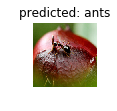

[[[-1.1246684  -1.0390445  -0.9705454  ... -0.01155927 -0.16568205
   -0.11430778]
  [-1.1589178  -1.0390445  -0.9705454  ... -0.18280679 -0.2170563
   -0.08005828]
  [-1.1075436  -1.073294   -0.9876702  ... -0.35405433 -0.2170563
   -0.09718303]
  ...
  [-1.2445416  -1.3130406  -1.3301654  ... -1.1246684  -1.0390445
   -1.0904187 ]
  [-1.3472902  -1.3130406  -1.3130406  ... -0.9705454  -0.9876702
   -1.004795  ]
  [-1.2959158  -1.3644148  -1.3472902  ... -0.9705454  -0.9705454
   -0.9705454 ]]

 [[-1.0028011  -0.862745   -0.792717   ... -1.265406   -1.405462
   -1.405462  ]
  [-1.0203081  -0.880252   -0.792717   ... -1.247899   -1.3879551
   -1.457983  ]
  [-1.0203081  -0.91526604 -0.827731   ... -1.1953781  -1.3879551
   -1.5105042 ]
  ...
  [-0.635154   -0.65266097 -0.65266097 ... -1.1428571  -1.160364
   -1.160364  ]
  [-0.565126   -0.60014    -0.53011197 ... -1.12535    -1.1428571
   -1.177871  ]
  [-0.617647   -0.65266097 -0.582633   ... -1.0903361  -1.107843
   -1.1428571 ]]

 [

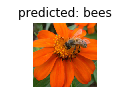

In [21]:
visualize_model(model_conv)

plt.ioff()
plt.show()